In [3]:
import gc, argparse, sys, os, errno
from functools import reduce
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from scipy import io
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

from collections import defaultdict
from sklearn.datasets import make_classification, make_regression, make_circles, make_moons, make_gaussian_quantiles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, \
    roc_curve, precision_recall_curve, average_precision_score, matthews_corrcoef, confusion_matrix
from statsmodels.robust.scale import mad
from scipy.stats import pearsonr

random_state = np.random.RandomState(1289237)  


Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [4]:
cd ~/projects/arts_collection/

/home/chenxupeng/projects/arts_collection


In [5]:
#setup figure template
figure_template_path = 'bin'
if figure_template_path not in sys.path:
    sys.path.append(figure_template_path)
from importlib import reload
import figure_template
#force reload of the module
reload(figure_template)
from figure_template import display_dataframe, embed_pdf_figure, embed_pdf_pages,std_plot,legendhandle

In [6]:
ls data

assign_array.npy     descriptors_num.txt  table/
category/            image_size.csv       test/
cluster_label.npy    index.html           train/
descriptors_all.npy  resized_img_256.h5   whole_sample_info.csv


In [7]:
assign_array = np.load('data/assign_array.npy')
sample_info = pd.read_csv('data/whole_sample_info.csv',index_col=0)

In [8]:
sample_info.head()

,old_class,descriptor_num,imgind,chn_name,new_class,old_class_num
index,,,,,,
ceramics/63.jpg,ceramics,1912,63,青釉堆塑谷仓罐,3,2
ceramics/823.jpg,ceramics,946,823,宜兴窑紫砂花口花盆,1,2
ceramics/189.jpg,ceramics,540,189,定窑白釉双系罐,3,2
ceramics/77.jpg,ceramics,340,77,青釉唾壶,4,2
ceramics/837.jpg,ceramics,116,837,仿定窑白釉三牺尊,4,2


## split dataset

In [12]:
def prepare_dataset():
    #assign_array
    y = np.array(sample_info.iloc[:,-2:])  #

    return train_test_split(assign_array, y, test_size=0.2, random_state=42)

In [13]:
def prepare_dataset_test():
    #assign_array
    y = np.array(sample_info.iloc[:,-2:])    #
    select_ind = np.arange(y.shape[0])
    np.random.shuffle(select_ind)
    
    return train_test_split(assign_array[select_ind[:4156]], y[select_ind[:4156]], test_size=0.2, random_state=42)

In [14]:
X_train, X_test, y_train, y_test= prepare_dataset()
print('number of training samples: {}, test samples: {}'.format(X_train.shape[0], X_test.shape[0]))


number of training samples: 5212, test samples: 1304


In [10]:
y_train,y_test = y_train[:,0],y_test[:,0] #预测新的class
#y_train,y_test = y_train[:,1],y_test[:,1] #预测旧的class


## visualize data

In [11]:
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
def PCA_plot_with_uca_score_sns(ax,data,sampleclass,batchinfo, method = 'PCA'):
    X = log_transform(data).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index],batchinfo.loc[plot_table.index]),axis=1)
    plot_table.columns = ['Dimension 1','Dimension 2','class','class_old']
    plot_table = plot_table.sort_values(by='class_old')
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]
    sns.scatterplot(ax=ax,data=plot_table,x="Dimension 1", y="Dimension 2",
                    palette=legendhandle(np.unique(plot_table.class_old)) , 
                    hue="class_old",style='class',s=50,linewidth=0.01,markers=filled_markers)
    


def log_transform(data, small = 0.01):
    return np.log2(data + small)

### quantitative metrics

In [12]:
def convert_label_to_int(sample_class):
    classes, counts = np.unique(sample_class, return_counts=True)
    classes = np.argmax(sample_class.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    return classes

def unsupervised_clustering_accuracy(y, y_pred):
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert len(y_pred) == len(y)
    u = np.unique(np.concatenate((y, y_pred)))
    n_clusters = len(u)
    mapping = dict(zip(u, range(n_clusters)))
    reward_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_ in mapping:
            reward_matrix[mapping[y_pred_], mapping[y_]] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    ind = linear_assignment(cost_matrix)
    return sum([reward_matrix[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind

def uca_scores(X,y, prediction_algorithm='knn'):
    from sklearn.metrics import adjusted_rand_score as ARI
    from sklearn.metrics import normalized_mutual_info_score as NMI
    from sklearn.metrics import silhouette_score
    from sklearn.mixture import GaussianMixture as GMM
    from sklearn.cluster import KMeans

    cluster_num = np.unique(y).shape[0]
    if prediction_algorithm == 'knn':
        labels_pred = KMeans(cluster_num, n_init=200).fit_predict(X) 
        #print(labels_pred)
        #print(np.unique(labels_pred,return_counts=True))
    elif prediction_algorithm == 'gmm':
        gmm = GMM(cluster_num)
        gmm.fit(X)
        labels_pred = gmm.predict(X)
    labels = y
    #asw_score = silhouette_score(X, labels)
    #nmi_score = NMI(labels, labels_pred)
    #ari_score = ARI(labels, labels_pred)
    labels_int = convert_label_to_int(labels)
    uca_score = unsupervised_clustering_accuracy(labels_int, labels_pred)[0]
    return uca_score,unsupervised_clustering_accuracy(labels_int, labels_pred)[1]

def get_uca_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    #knn_score_ = knn_score(X_, y_)
    uca_score,ind = uca_scores(X_, y_, prediction_algorithm)
    return uca_score

def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

def get_knn_score(data,sampleclass,method_PCA = True,prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    X_, y_ = X_pca, sampleclass.loc[data.columns.values].values.ravel() 
    knn_score_ = knn_score(X_, y_)
    return knn_score_

In [13]:
BoW_Training_x = assign_array
BoW_Training_y =  np.array(sample_info.iloc[:,-2:])   
input_table = pd.DataFrame(BoW_Training_x)
class_label = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),
                                              np.array(BoW_Training_y[:,0]).reshape(-1,1)),axis=1),columns=['sample','class'])
class_label = class_label.set_index('sample').astype('str')
context_label = pd.DataFrame(np.concatenate((np.array(input_table.index).reshape(-1,1),
                                               np.array(BoW_Training_y[:,1]).reshape(-1,1)),axis=1),columns=['sample','class_old'])
context_label = context_label.set_index('sample').astype('str')

Text(0.5, 1.0, 'Visualize Data Distribution')

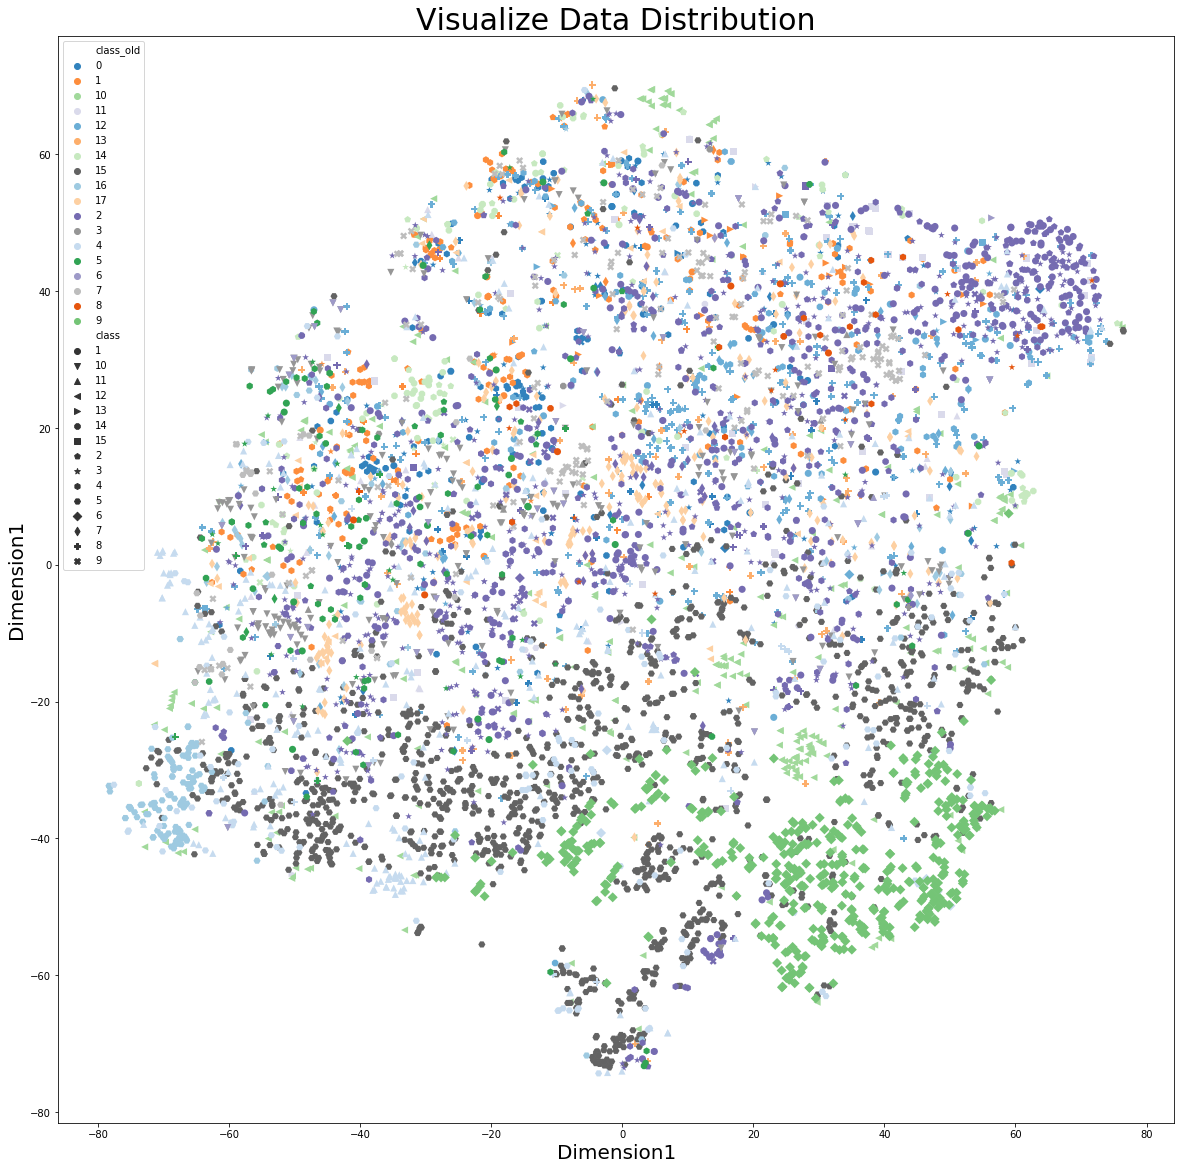

In [32]:
input_table = pd.DataFrame(BoW_Training_x)

fig, ax = plt.subplots(1,figsize=(20,20))
PCA_plot_with_uca_score_sns(ax,input_table.T,class_label,context_label,method='tSNE')

ax.set_xlabel('Dimension1',fontsize=20)
ax.set_ylabel('Dimension1',fontsize=20)
ax.set_title('Visualize Data Distribution',fontsize=30)
#fig.savefig(savepath+'RLE with Limma.eps')
#embed_pdf_figure()


In [33]:
get_uca_score(input_table.T,class_label)

0.22252915899324738

In [34]:
get_uca_score(input_table.T,context_label) #old class

0.2254450583179865

数据并不太按照class聚集，但是也不按照old_class聚集，

## scale data

In [15]:
def preprocess(data,method='minmax'):
    if method =='minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
    elif method =='zscore':
        scaler = StandardScaler()
        scaler.fit(data)
    elif method =='robust':
        scaler = RobustScaler()
        scaler.fit(data)
    return scaler.transform(data),scaler

In [16]:
X_train = preprocess(X_train,method='robust')[0]
X_test =  preprocess(X_test,method='robust')[0]

## train classifier

In [17]:
# Inherently multiclass:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC #(setting multi_class=”crammer_singer”)
from sklearn.linear_model import LogisticRegression #(setting multi_class=”multinomial”)
from sklearn.linear_model import LogisticRegressionCV #(setting multi_class=”multinomial”)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
# Multiclass as One-Vs-One:
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier #(setting multi_class = “one_vs_one”)
# Multiclass as One-Vs-All:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier #(setting multi_class = “one_vs_rest”)
from sklearn.svm import LinearSVC #(setting multi_class=”ovr”)
from sklearn.linear_model import LogisticRegression #(setting multi_class=”ovr”)
from sklearn.linear_model import LogisticRegressionCV #(setting multi_class=”ovr”)
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


In [18]:
from sklearn.model_selection import train_test_split
import torch
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
import torch.nn as nn # prebuilt functions specific to neural networks
import torch.utils.data

In [19]:
y_train.shape,X_train.shape

((5212, 15), (5212, 50))

In [20]:
models_all = {'BernoulliNB':BernoulliNB(),
            'DecisionTreeClassifier':DecisionTreeClassifier(),
            'ExtraTreeClassifier':ExtraTreeClassifier(),  
            'ExtraTreesClassifier':ExtraTreesClassifier(),
            'GaussianNB':GaussianNB(),
            'KNeighborsClassifier':KNeighborsClassifier(),
            'LabelPropagation':LabelPropagation(),
            'LabelSpreading':LabelSpreading(),
            'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'LinearSVC': LinearSVC(multi_class='crammer_singer'),
            'LogisticRegression':LogisticRegression('multinomial'),
            'LogisticRegressionCV':LogisticRegressionCV('multinomial'),
            'MLPClassifier':MLPClassifier(),
            'NearestCentroid':NearestCentroid(),
            'QuadraticDiscriminantAnalysis':QuadraticDiscriminantAnalysis(),
            'RandomForestClassifier':RandomForestClassifier(),
            'RidgeClassifier':RidgeClassifier(),
            'RidgeClassifierCV':RidgeClassifierCV(),
            'NuSVC': NuSVC(),
            'SVC':SVC(),
            'GaussianProcessClassifier':GaussianProcessClassifier(multi_class = 'one_vs_one'),
            'GradientBoostingClassifier':GradientBoostingClassifier(),
            'GaussianProcessClassifier':GaussianProcessClassifier(multi_class = 'one_vs_rest'),
            'LinearSVC':LinearSVC(multi_class='ovr'),
            'LogisticRegression':LogisticRegression(multi_class='ovr'),
            'LogisticRegressionCV':LogisticRegressionCV(multi_class='ovr'),
            'SGDClassifier':SGDClassifier(),
            'Perceptron':Perceptron(),
            'PassiveAggressiveClassifier':PassiveAggressiveClassifier()                       
}

In [21]:
def Model(width,height,modelname):
    '''
    if modelname=='lr':
        model = LogisticRegression()
    elif modelname=='svm':
        model = SVC()
    elif modelname=='xgb':
        model = GradientBoostingClassifier()
    elif modelname=='kn':
        model = neighbors.KNeighborsClassifier(n_neighbors=4, algorithm='brute')
    elif modelname=='rf':
        model = RandomForestClassifier(n_estimators=10,  max_depth=12, n_jobs=5)
    elif modelname=='gp':
        kernel = 1.0 * DotProduct(sigma_0=1.0)**4
        model = GaussianProcessClassifier(kernel = kernel, optimizer=None,verbose=1)
    elif modelname=='mlp':
        model = MLPClassifier(verbose=1)
    '''
    model = models_all[modelname]
    
    print (model)
    model.fit(X_train, y_train)
    print ('finish training')
    y_pred = model.predict(X_test)
    
    fig, ax = plt.subplots(1,2,figsize=(width,height))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

## evaluate

In [1]:
def report_metrics(y_test, y_pred):
    scorers = {'accuracy': accuracy_score(y_test, y_pred),
           'recall': recall_score(y_test, y_pred,average=None),
           'precision': precision_score(y_test, y_pred,average=None),
           'f1': f1_score(y_test, y_pred,average=None),
           'mcc': matthews_corrcoef(y_test, y_pred)
    }
    for metric in scorers.keys():
        print('{} = {}'.format(metric, scorers[metric]))
    return scorers['f1'],scorers['accuracy'],scorers['recall'],scorers['precision'],scorers['mcc']

In [23]:

def report_metrics_plot(y_test, y_pred):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    f1,accuracy,recall,precision,mcc = report_metrics(y_test, y_pred)
    metrics_1 = np.concatenate((recall.reshape(-1,1),precision.reshape(-1,1),f1.reshape(-1,1)),axis=1)
    sns.stripplot(data=metrics_1,ax=ax[0])
    sns.boxplot(data=metrics_1,ax=ax[0])
    ax[0].set_xticklabels(['recall','precision','f1'])
    metrics_2=np.array([accuracy,mcc])
    sns.barplot(data=pd.DataFrame(metrics_2.reshape(1,-1)),ax=ax[1])
    ax[1].set_xticklabels(['accuracy','mcc'])

In [24]:
interact(Model,modelname= Dropdown(options=[i for i in models_all.keys()],value='LogisticRegression'),
                width =FloatSlider(min=12,max=24,step=2,value=15),
                 height= FloatSlider(min=4,max=8,step=2,value=5),
        )

interactive(children=(FloatSlider(value=15.0, description='width', max=24.0, min=12.0, step=2.0), FloatSlider(value=5.0, description='height', max=8.0, min=4.0, step=2.0), Dropdown(description='modelname', index=10, options=('BernoulliNB', 'DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'MLPClassifier', 'NearestCentroid', 'QuadraticDiscriminantAnalysis', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'NuSVC', 'SVC', 'GaussianProcessClassifier', 'GradientBoostingClassifier', 'SGDClassifier', 'Perceptron', 'PassiveAggressiveClassifier'), value='LogisticRegression'), Output()), _dom_classes=('widget-interact',))

<function __main__.Model(width, height, modelname)>

## tuning parameters

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# model with just 3 features selected
clf_fs_cv = Pipeline([
    
    ('feature_selector', SelectKBest(f_classif, k=10)),
    ('svc', SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', probability=True))
])

scores = cross_val_score(clf_fs_cv, X_train, y_train, cv=2)

In [26]:
scores

array([0.35670498, 0.36433513])

In [27]:
from sklearn.model_selection import GridSearchCV

# Train classifiers.
kernel_values = [  'rbf']#'linear', 'poly',
param_grid = {'C': np.logspace(-3, 2, 3), 'gamma': np.logspace(-3, 2, 3), 'kernel': kernel_values}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3,verbose=2,n_jobs=1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. C=0.001, gamma=0.001, kernel=rbf, total=   1.7s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.001, kernel=rbf, total=   1.6s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] ................. C=0.001, gamma=0.001, kernel=rbf, total=   1.6s
[CV] C=0.001, gamma=0.31622776601683794, kernel=rbf ..................
[CV] ... C=0.001, gamma=0.31622776601683794, kernel=rbf, total=   1.8s
[CV] C=0.001, gamma=0.31622776601683794, kernel=rbf ..................
[CV] ... C=0.001, gamma=0.31622776601683794, kernel=rbf, total=   1.9s
[CV] C=0.001, gamma=0.31622776601683794, kernel=rbf ..................
[CV] ... C=0.001, gamma=0.31622776601683794, kernel=rbf, total=   1.8s
[CV] C=0.001, gamma=100.0, kernel=rbf ................................
[CV] ................. C=0.001, gamma=100.0, kernel=rbf, total=   1.7s
[CV] C=0.001, gamma=100.0, kernel=rbf ................................
[CV] ................. C=0.001, gamma=100.0, kernel=rbf, total=   1.7s
[CV] C=0.001, gamma=100.0, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([1.00000e-03, 3.16228e-01, 1.00000e+02]), 'gamma': array([1.00000e-03, 3.16228e-01, 1.00000e+02]), 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [28]:
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'} with a score of 0.53


accuracy = 0.495398773006135
recall = [0.17857143 0.09375    0.13076923 0.54054054 0.859375   0.82758621
 0.48148148 0.20652174 0.60869565 0.38028169 0.375      0.56
 0.         0.16129032 0.        ]
precision = [0.25       0.3        0.20987654 0.26845638 0.67237164 0.81818182
 0.43333333 0.32758621 0.68292683 0.65853659 0.67741935 0.67741935
 0.         0.20833333 0.        ]
f1 = [0.20833333 0.14285714 0.16113744 0.35874439 0.75445816 0.82285714
 0.45614035 0.25333333 0.64367816 0.48214286 0.48275862 0.61313869
 0.         0.18181818 0.        ]
mcc = 0.42461828590497147


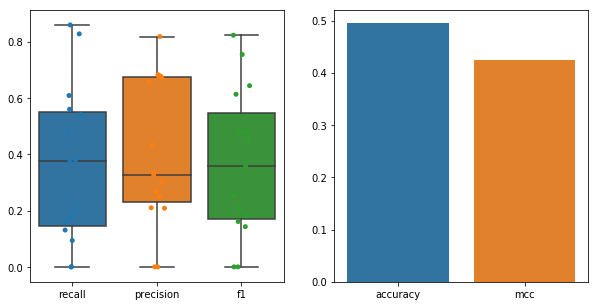

In [29]:
best_clf = grid.best_estimator_
best_clf.probability = True
y_pred = best_clf.fit(X_train, y_train).predict(X_test)
report_metrics_plot(y_test, y_pred)